In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
%reload_ext autoreload

In [26]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [27]:
import numpy as np
import pandas as pd

import cortex

import matplotlib.pyplot as plt
import seaborn as sns

from src.trainer import Trainer
from src.settings import ResultSetting

from src.utils import put_values_on_mask
from src.utils import read_result_meta, get_surface_dict, delete_empty_result

from src.plot_utils import plot_flatmap_from_vertex
from src.configurations import timescale_ranges

from voxelwise_tutorials.io import load_hdf5_sparse_array

In [28]:
from src.configurations import config_plotting

config_plotting("paper")

In [29]:
surfaces_json = ".temp/fmri/bling/surfaces.json"
surfaces_dir = "/mnt/raid/bling/share/pycortex_store"

mapper_dir = "/mnt/raid/bling/share/mappers"

result_metric = "r2"
result_meta_dir = ".temp/result_meta/bling"

subjects_ids = ["COL", "GFW", "TYE"]
languages = ["en", "zh"]

fsaverage_surface = "fsaverage"

yeos_label_dir = ".temp/misc/Yeo_JNeurophysiol11_FreeSurfer/fsaverage/label"

alpha = 0.05
alpha_pred_acc = None

In [30]:
timescale_data = {}

for subject_id in subjects_ids:
    surface_dict = get_surface_dict(subject_id)

    subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
    subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

    trainer_en_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    )
    trainer_zh_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"
    )

    feature_file_en = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    feature_file_zh = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"

    mapper_file = os.path.join(mapper_dir, f"{subject_id}_fsaverage_mapper.hdf")

    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_en_file,
        subject_setting_path=subject_file_en,
        feature_setting_path=feature_file_en,
    )
    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_zh_file,
        subject_setting_path=subject_file_zh,
        feature_setting_path=feature_file_zh,
    )

    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()

    en_stats = np.load(en_config["stats_path"])
    zh_stats = np.load(zh_config["stats_path"])

    keyword = f"test_{result_metric}_selectivity_mask"
    p_val_keyword = f"test_p_values_{result_metric}_mask"

    timescale_en, _ = put_values_on_mask(
        en_stats[keyword],
        zh_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(2, 512),
    )

    timescale_zh, _ = put_values_on_mask(
        zh_stats[keyword],
        zh_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(2, 512),
    )

    timescale_en = np.nan_to_num(timescale_en)
    timescale_zh = np.nan_to_num(timescale_zh)
    
    # project to fsaverage
    mapper = load_hdf5_sparse_array(mapper_file, key="voxel_to_fsaverage")

    projected_en = timescale_en @ mapper.T
    projected_zh = timescale_zh @ mapper.T

    # drop nan
    timescale_data[subject_id] = {
        "en": projected_en,
        "zh": projected_zh,
    }

In [43]:
# iterate over subjects and timescales range
timescales = []
for subject_id in subjects_ids:
    for k in timescale_ranges.keys():
        range = timescale_ranges[k]

        cur_en_timescale = timescale_data[subject_id]["en"]
        cur_zh_timescale = timescale_data[subject_id]["zh"]

        # if values are not withing range, set to zero, otherwise keep the value
        cur_en_timescale = (cur_en_timescale >= range[0]) & (cur_en_timescale <= range[1]).astype(int)
        cur_zh_timescale = (cur_zh_timescale >= range[0]) & (cur_zh_timescale <= range[1]).astype(int)
            
        timescales.append({
            "subject_id": subject_id,
            "timescale": k,
            "language": "en",
            "data": cur_en_timescale,
        })
        
        timescales.append({
            "subject_id": subject_id,
            "timescale": k,
            "language": "zh",
            "data": cur_zh_timescale,
        })
        
timescales_df = pd.DataFrame(timescales)

In [32]:
# for subject_id in subjects_ids:
    
#     lang = "en"
#     en_vertex = cortex.Vertex(timescale_data[subject_id][lang], fsaverage_surface, vmin=8, vmax=256, cmap="rainbow",)
#     print(f"subject: {subject_id}, lang: {lang}")
#     plot_flatmap_from_vertex(en_vertex, title=f"Timescale Selectivity of {subject_id} ({lang})")
#     plt.show()
    
#     lang="zh"
#     zh_vertex = cortex.Vertex(timescale_data[subject_id][lang], fsaverage_surface, vmin=8, vmax=256, cmap="rainbow",)
#     print(f"subject: {subject_id}, lang: {lang}")
#     plot_flatmap_from_vertex(zh_vertex, title=f"Timescale Selectivity of {subject_id} ({lang})")
#     plt.show()

# YEO's Parcelation

In [33]:
import nibabel as nib

In [34]:
areas_to_parcels_dict = {
    "DMN": ["DefaultA-Default_A", "DefaultB-Default_B", "DefaultC-Default_C"],
    "Control": ["ContA-Control_A", "ContB-Control_B", "ContC-Control_C"],
    "TempPar": ["TempPar-Temporal_Parietal"],
    "DorsAttn": ["DorsAttnA-Dorsal_Attention_A", "DorsAttnB-Dorsal_Attention_B"],
    "VentAttn": [
        "SalVentAttnA-Salience_Ventral_Attention_A",
        "SalVentAttnB-Salience_Ventral_Attention_B",
    ],
    "VisCent": ["VisCent-Visual_A", "VisPeri-Visual_B"],
    "SomMot": ["SomMotA-Somamotor_A", "SomMotB-Somamotor_B"],
    "Limbic": ["LimbicA-Limbic_A", "LimbicB-Limbic_B"],
}

colors_dict = {
    "DMN": "blue",
    "Control": "green",
    "TempPar": "red",
    "DorsAttn": "orange",
    "VentAttn": "purple",
    "VisCent": "brown",
    "SomMot": "pink",
    "Limbic": "gray",
}

annot_name_to_functional_name_dict = {
    17: {
        b"FreeSurfer_Defined_Medial_Wall_0": "FreeSurfer_Defined_Medial_Wall",
        b"17Networks_1": "VisCent-Visual_A",
        b"17Networks_2": "VisPeri-Visual_B",
        b"17Networks_3": "SomMotA-Somamotor_A",
        b"17Networks_4": "SomMotB-Somamotor_B",
        b"17Networks_5": "DorsAttnA-Dorsal_Attention_A",
        b"17Networks_6": "DorsAttnB-Dorsal_Attention_B",
        b"17Networks_7": "SalVentAttnA-Salience_Ventral_Attention_A",
        b"17Networks_8": "SalVentAttnB-Salience_Ventral_Attention_B",
        b"17Networks_9": "LimbicB-Limbic_B",
        b"17Networks_10": "LimbicA-Limbic_A",
        b"17Networks_11": "ContC-Control_C",
        b"17Networks_12": "ContA-Control_A",
        b"17Networks_13": "ContB-Control_B",
        b"17Networks_14": "TempPar-Temporal_Parietal",
        b"17Networks_15": "DefaultC-Default_C",
        b"17Networks_16": "DefaultA-Default_A",
        b"17Networks_17": "DefaultB-Default_B",
    },
    7: {
        b"FreeSurfer_Defined_Medial_Wall_0": "FreeSurfer_Defined_Medial_Wall",
        b"7Networks_1": "Visual",
        b"7Networks_2": "Somamotor",
        b"7Networks_3": "Dorsal attention",
        b"7Networks_4": "Ventral attention",
        b"7Networks_5": "Limbic",
        b"7Networks_6": "Frontoparietal",
        b"7Networks_7": "Default mode",
    },
}

In [35]:
lh_annot = nib.freesurfer.io.read_annot(
    os.path.join(yeos_label_dir, f"lh.Yeo2011_17Networks_N1000.annot")
)
rh_annot = nib.freesurfer.io.read_annot(
    os.path.join(yeos_label_dir, f"rh.Yeo2011_17Networks_N1000.annot")
)

num_fsaverage_vertices = 327684
num_networks = 17

lh_mask = np.arange(int(num_fsaverage_vertices // 2))
rh_mask = np.arange(int(num_fsaverage_vertices // 2), num_fsaverage_vertices)


In [36]:
functional_name_to_annot_indices_dict = {
    functional_name: int(str(annot_network_name).split("_")[-1].strip("'"))
    for annot_network_name, functional_name in annot_name_to_functional_name_dict[
        num_networks
    ].items()
}

area_name_to_annot_indices_dict = {
    area_name: [
        functional_name_to_annot_indices_dict[annot_network_name]
        for annot_network_name in annot_network_names
    ]
    for area_name, annot_network_names in areas_to_parcels_dict.items()
}

In [44]:
# product of subject_ids, languages, timescale_ranges, areas_to_parcels_dict

from itertools import product

parcel_correlations = []

for subject_id, lang, timescale, area_name in product(subjects_ids, languages, timescale_ranges.keys(), areas_to_parcels_dict.keys()):
    parcel_annot_indices = area_name_to_annot_indices_dict[area_name]
    parcel_included_vertices = np.array(
        list(
            set(
                list(
                    lh_mask[np.where(np.isin(lh_annot[0], parcel_annot_indices))[0]]
                )
                + list(
                    rh_mask[np.where(np.isin(rh_annot[0], parcel_annot_indices))[0]]
                )
            )
        )
    )
    parcel_mask = np.zeros(num_fsaverage_vertices)
    parcel_mask[parcel_included_vertices] = 1
    
    # correlate timescale with parcel_mask
    data = timescales_df[
        (timescales_df["subject_id"] == subject_id)
        & (timescales_df["language"] == lang)
        & (timescales_df["timescale"] == timescale)
    ]["data"].values[0]
    corr = np.corrcoef(data, parcel_mask)[0, 1]
    
    parcel_correlations.append({
        "subject_id": subject_id,
        "language": lang,
        "timescale": timescale,
        "area": area_name,
        "correlation": corr,
    })
    

In [45]:
parcel_correlation_df = pd.DataFrame(parcel_correlations)
parcel_correlation_df.head()

,subject_id,language,timescale,area,correlation
0,COL,en,2_4_words,DMN,-0.000741
1,COL,en,2_4_words,Control,-0.008014
2,COL,en,2_4_words,TempPar,0.000470
3,COL,en,2_4_words,DorsAttn,-0.008325
4,COL,en,2_4_words,VentAttn,0.001412


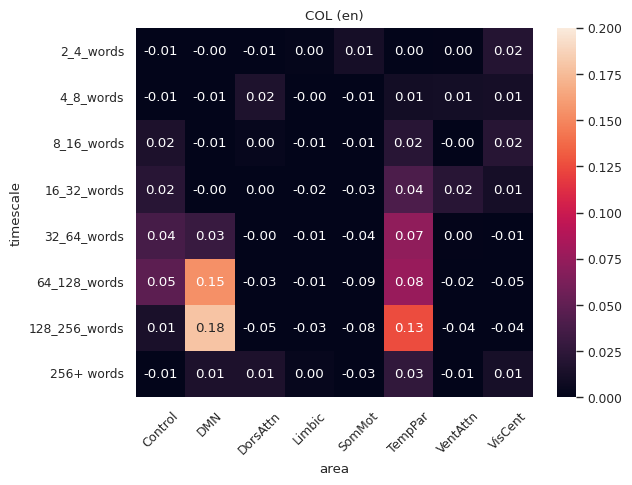

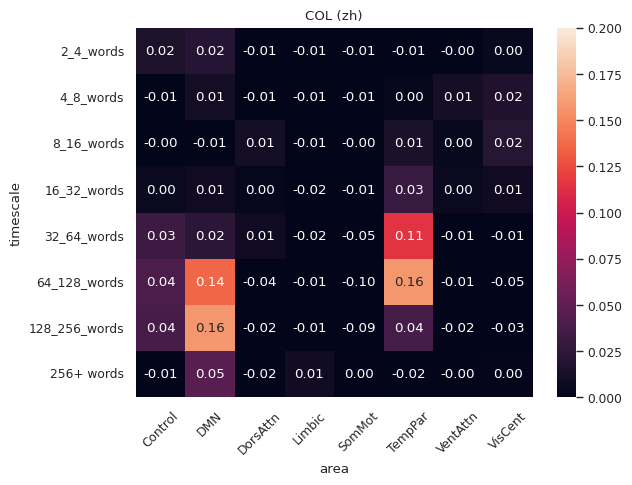

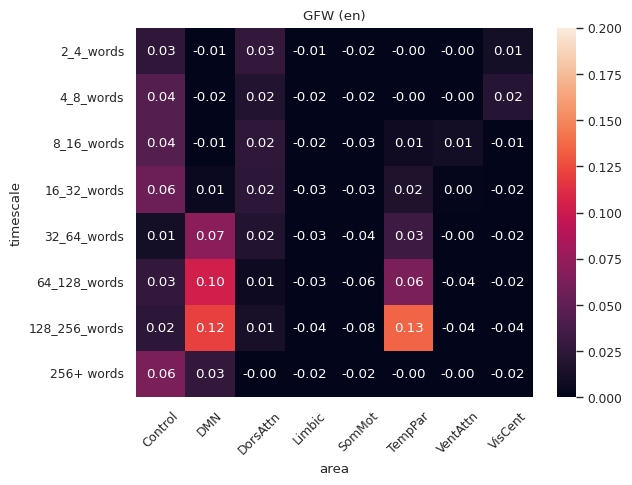

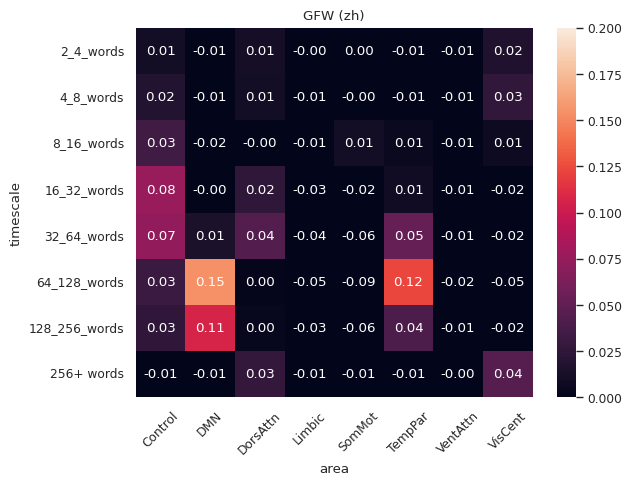

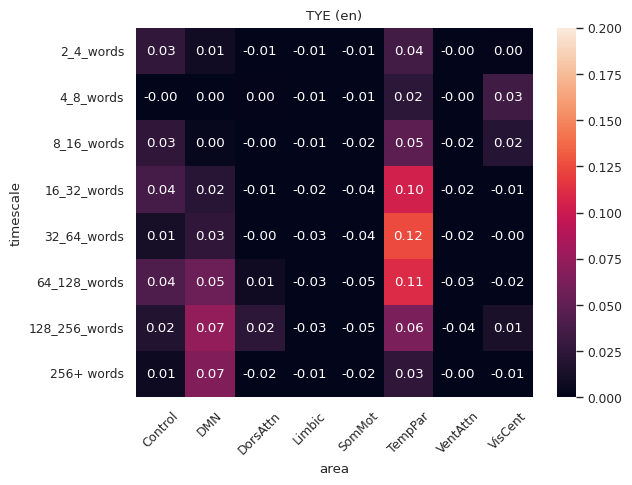

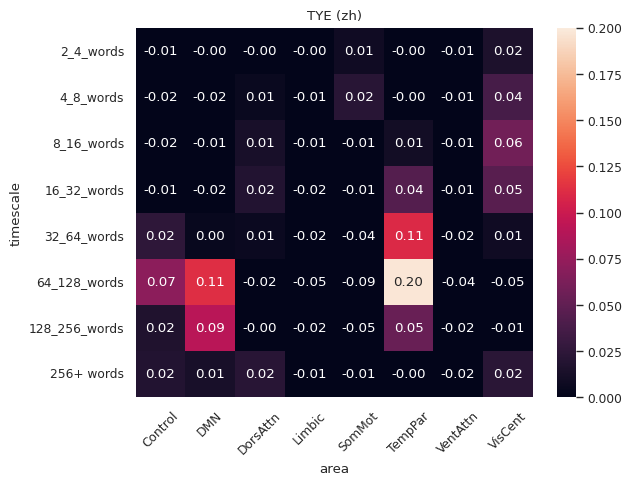

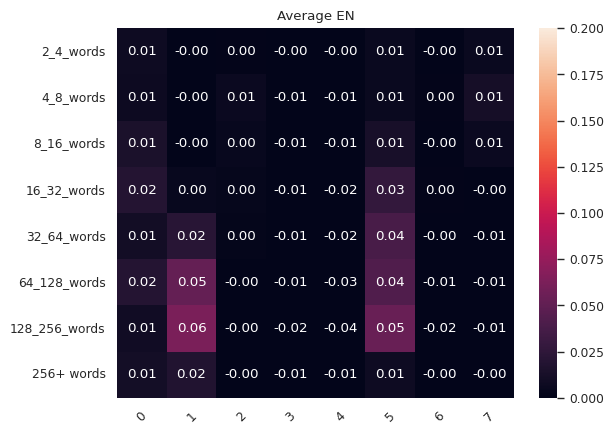

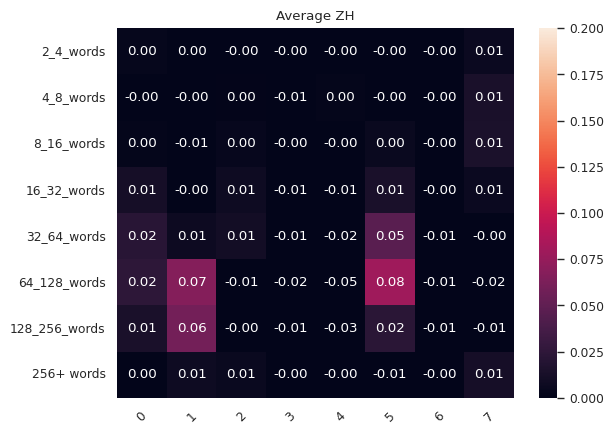

In [67]:
# now create heatmap for subject and language
data_avg_en = np.zeros((len(timescale_ranges.keys()), len(areas_to_parcels_dict.keys())))
data_avg_zh = np.zeros((len(timescale_ranges.keys()), len(areas_to_parcels_dict.keys())))

for subject_id, lang in product(subjects_ids, languages):
    data_df = parcel_correlation_df[parcel_correlation_df["subject_id"]==subject_id]
    data_df = data_df[data_df["language"]==lang]

    # drop subject and language columns
    data_df = data_df.pivot(index="timescale", columns="area", values="correlation")
    # rearange index to timescale_ranges
    data_df = data_df.reindex(index=timescale_ranges.keys())
    
    # add to data_avg
    if lang == "en":
        data_avg_en += data_df.values
    else:
        data_avg_zh += data_df.values
    # plot heatmap
    sns.heatmap(data_df, annot=True, vmin=0, vmax=0.2, fmt=".2f")
    # xticks tilt
    plt.xticks(rotation=45)
    plt.title(f"{subject_id} ({lang})")
    plt.show()
    
    
x_tick_labels = sorted(list(areas_to_parcels_dict.keys()))
# plot average en
data_avg_en /= len(subjects_ids) * len(languages)
sns.heatmap(data_avg_en, annot=True, vmin=0, vmax=0.2, fmt=".2f")
plt.xticks(np.arange(len(areas_to_parcels_dict.keys())) + 0.5, x_tick_labels)
plt.xticks(rotation=45)
plt.yticks(np.arange(len(timescale_ranges.keys())) + 0.5, timescale_ranges.keys())
plt.yticks(rotation=0)
plt.title("Average EN")
plt.show()

# plot average ZH
data_avg_zh /= len(subjects_ids) * len(languages)
sns.heatmap(data_avg_zh, annot=True, vmin=0, vmax=0.2, fmt=".2f")
plt.xticks(np.arange(len(areas_to_parcels_dict.keys())) + 0.5, x_tick_labels)
plt.xticks(rotation=45)
plt.yticks(np.arange(len(timescale_ranges.keys())) + 0.5, timescale_ranges.keys())
plt.yticks(rotation=0)
plt.title("Average ZH")


plt.show()

In [74]:
sorted(list(areas_to_parcels_dict.keys()))

['Control',
 'DMN',
 'DorsAttn',
 'Limbic',
 'SomMot',
 'TempPar',
 'VentAttn',
 'VisCent']

In [69]:
data_df[data_df["area"]=="DMN"]

KeyError: 'area'